In [1]:
from sklearn import datasets
import pandas as pd

import pyspark
import findspark
findspark.init()
import re
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
spark = SparkSession.builder.appName('Hw4').getOrCreate()

In [2]:
#I will be opting the second option i.e. KMeans as I have worked with the Iris dataset in the past & I'm familiar with it.

# Option 2: K-means

#Task 1: Import the Iris dataset

In [3]:
# load iris dataset
iris = datasets.load_iris()

iris_df = pd.DataFrame(iris.data) #Creating pandas dataframe

iris_df['target'] = iris.target #Defining and naming the target column

iris_df.columns = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'target'] #Naming other columns in the dataframe

iris_df.dropna(how = "all", inplace = True) # Removing NA values if any

In [4]:
iris_df.head() #Checking the dataframe

,sepal_len,sepal_wid,petal_len,petal_wid,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
print(iris_df.shape) #Checking the number of rows and columns

(150, 5)


In [6]:
print(iris_df.info()) #Getting additional insights on the dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sepal_len  150 non-null    float64
 1   sepal_wid  150 non-null    float64
 2   petal_len  150 non-null    float64
 3   petal_wid  150 non-null    float64
 4   target     150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 6.4 KB
None


In [7]:
spark_iris = spark.createDataFrame(iris_df) #Converting the pandas dataframe to a spark dataframe

In [8]:
spark_iris.show() #Displaying the spark dataframe

+---------+---------+---------+---------+------+
|sepal_len|sepal_wid|petal_len|petal_wid|target|
+---------+---------+---------+---------+------+
|      5.1|      3.5|      1.4|      0.2|     0|
|      4.9|      3.0|      1.4|      0.2|     0|
|      4.7|      3.2|      1.3|      0.2|     0|
|      4.6|      3.1|      1.5|      0.2|     0|
|      5.0|      3.6|      1.4|      0.2|     0|
|      5.4|      3.9|      1.7|      0.4|     0|
|      4.6|      3.4|      1.4|      0.3|     0|
|      5.0|      3.4|      1.5|      0.2|     0|
|      4.4|      2.9|      1.4|      0.2|     0|
|      4.9|      3.1|      1.5|      0.1|     0|
|      5.4|      3.7|      1.5|      0.2|     0|
|      4.8|      3.4|      1.6|      0.2|     0|
|      4.8|      3.0|      1.4|      0.1|     0|
|      4.3|      3.0|      1.1|      0.1|     0|
|      5.8|      4.0|      1.2|      0.2|     0|
|      5.7|      4.4|      1.5|      0.4|     0|
|      5.4|      3.9|      1.3|      0.4|     0|
|      5.1|      3.5

In [9]:
spark_iris = spark_iris.drop("target") #As we need to use k-means i.e. unsupervised learning, we get rid of the target column

spark_iris.show() #Displaying the spark dataframe post dropping the target column that will be used in k-means

+---------+---------+---------+---------+
|sepal_len|sepal_wid|petal_len|petal_wid|
+---------+---------+---------+---------+
|      5.1|      3.5|      1.4|      0.2|
|      4.9|      3.0|      1.4|      0.2|
|      4.7|      3.2|      1.3|      0.2|
|      4.6|      3.1|      1.5|      0.2|
|      5.0|      3.6|      1.4|      0.2|
|      5.4|      3.9|      1.7|      0.4|
|      4.6|      3.4|      1.4|      0.3|
|      5.0|      3.4|      1.5|      0.2|
|      4.4|      2.9|      1.4|      0.2|
|      4.9|      3.1|      1.5|      0.1|
|      5.4|      3.7|      1.5|      0.2|
|      4.8|      3.4|      1.6|      0.2|
|      4.8|      3.0|      1.4|      0.1|
|      4.3|      3.0|      1.1|      0.1|
|      5.8|      4.0|      1.2|      0.2|
|      5.7|      4.4|      1.5|      0.4|
|      5.4|      3.9|      1.3|      0.4|
|      5.1|      3.5|      1.4|      0.3|
|      5.7|      3.8|      1.7|      0.3|
|      5.1|      3.8|      1.5|      0.3|
+---------+---------+---------+---

#Task 2: Build a K-means model to classify the species of Iris. 

In [10]:
#In order to apply k-means model, we need to create a vector assembler for which we would need to define an input vector

input = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid'] #Defining columns to be used as input in a list

In [11]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [12]:
vector_assem = VectorAssembler(inputCols = input, outputCol = "Features") #Creating a vector assembler

In [13]:
final_data = vector_assem.transform(spark_iris) #Appending the vector assembler to our dataframe

In [14]:
final_data.show() #Displaying our dataframe with the vector assembler

+---------+---------+---------+---------+-----------------+
|sepal_len|sepal_wid|petal_len|petal_wid|         Features|
+---------+---------+---------+---------+-----------------+
|      5.1|      3.5|      1.4|      0.2|[5.1,3.5,1.4,0.2]|
|      4.9|      3.0|      1.4|      0.2|[4.9,3.0,1.4,0.2]|
|      4.7|      3.2|      1.3|      0.2|[4.7,3.2,1.3,0.2]|
|      4.6|      3.1|      1.5|      0.2|[4.6,3.1,1.5,0.2]|
|      5.0|      3.6|      1.4|      0.2|[5.0,3.6,1.4,0.2]|
|      5.4|      3.9|      1.7|      0.4|[5.4,3.9,1.7,0.4]|
|      4.6|      3.4|      1.4|      0.3|[4.6,3.4,1.4,0.3]|
|      5.0|      3.4|      1.5|      0.2|[5.0,3.4,1.5,0.2]|
|      4.4|      2.9|      1.4|      0.2|[4.4,2.9,1.4,0.2]|
|      4.9|      3.1|      1.5|      0.1|[4.9,3.1,1.5,0.1]|
|      5.4|      3.7|      1.5|      0.2|[5.4,3.7,1.5,0.2]|
|      4.8|      3.4|      1.6|      0.2|[4.8,3.4,1.6,0.2]|
|      4.8|      3.0|      1.4|      0.1|[4.8,3.0,1.4,0.1]|
|      4.3|      3.0|      1.1|      0.1

In [15]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [16]:
kmeans = KMeans (featuresCol="Features", k=5) #Creating the k-means model and passing the vector assembler values. I have decided to try k=5

In [17]:
model = kmeans.fit(final_data) #Passing the dataframe to the k-means model

In [18]:
model #Checking if the k-means model has been correctly created

KMeansModel: uid=KMeans_cc4bfeca6a97, k=5, distanceMeasure=euclidean, numFeatures=4

In [19]:
model.transform(final_data).groupBy("Prediction").count().show() #Getting the count of prediction & count

+----------+-----+
|Prediction|count|
+----------+-----+
|         1|   50|
|         2|   26|
|         0|   22|
|         3|   30|
|         4|   22|
+----------+-----+



In [20]:
predicted_data = model.transform(final_data) #Appending the predictions to the datframe

In [21]:
predicted_data.show() #Displaying the prediction with our dataframe

+---------+---------+---------+---------+-----------------+----------+
|sepal_len|sepal_wid|petal_len|petal_wid|         Features|prediction|
+---------+---------+---------+---------+-----------------+----------+
|      5.1|      3.5|      1.4|      0.2|[5.1,3.5,1.4,0.2]|         1|
|      4.9|      3.0|      1.4|      0.2|[4.9,3.0,1.4,0.2]|         1|
|      4.7|      3.2|      1.3|      0.2|[4.7,3.2,1.3,0.2]|         1|
|      4.6|      3.1|      1.5|      0.2|[4.6,3.1,1.5,0.2]|         1|
|      5.0|      3.6|      1.4|      0.2|[5.0,3.6,1.4,0.2]|         1|
|      5.4|      3.9|      1.7|      0.4|[5.4,3.9,1.7,0.4]|         1|
|      4.6|      3.4|      1.4|      0.3|[4.6,3.4,1.4,0.3]|         1|
|      5.0|      3.4|      1.5|      0.2|[5.0,3.4,1.5,0.2]|         1|
|      4.4|      2.9|      1.4|      0.2|[4.4,2.9,1.4,0.2]|         1|
|      4.9|      3.1|      1.5|      0.1|[4.9,3.1,1.5,0.1]|         1|
|      5.4|      3.7|      1.5|      0.2|[5.4,3.7,1.5,0.2]|         1|
|     

#Task 3: Report the original performance using Silhouette score. 

In [22]:
evaluator = ClusteringEvaluator(featuresCol='Features',metricName='silhouette', distanceMeasure='squaredEuclidean') 
#Defining the cluster evaluator which will measure how close each point in one cluster is to points in neighbouring clusters 

In [23]:
silhouette = evaluator.evaluate(predicted_data) #Passing the predictions and features as input to the evaluator

In [24]:
silhouette #Displaying the sillhouette value

0.6164493422227454

#Task 4: Try to improve the performance of the original model by trying at least 10 different k values.

In [25]:
silhouette_values = [] #creating an empty list to append the silhouette values to later on

In [26]:
evaluator_new = ClusteringEvaluator(featuresCol='Features',metricName='silhouette', distanceMeasure='squaredEuclidean') #Defining a new evaluator

for K in range (2,12): #We select 10 values from 2 to 12
    clusters = KMeans(featuresCol = 'Features', k = K) #Passing the features column and keeping k i the range of 2 to 12
    model_fit = clusters.fit(final_data) #Passing the dataframe through 'clusters'
    model_transform = model_fit.transform(final_data) #Passing the dataframe throgh 'model_fit'
    evaluation_score = evaluator_new.evaluate(model_transform) #Passing 'model_transform' as an input to the evaluator
    
    silhouette_values.append(evaluation_score) #Appending the values to the list silhouette_values

In [27]:
silhouette_values #Displaying the list

[0.8503512229251472,
 0.735659605433223,
 0.6787998609321808,
 0.6164493422227454,
 0.6446709559107205,
 0.47412305969794477,
 0.597938482069107,
 0.5888154391847682,
 0.577510016142841,
 0.48168539524421694]

Text(0, 0.5, 'Silhouette')

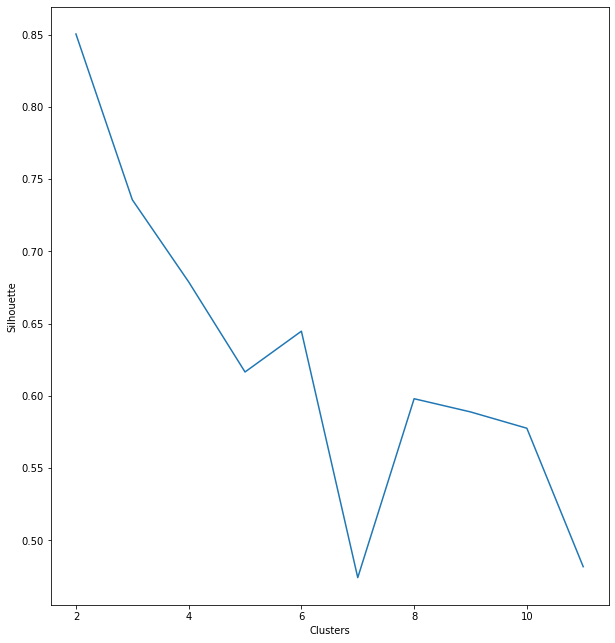

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(10,11)) #Defining the plot window

ax.plot(range(2,12),silhouette_values) #Passing the list and defining the range of values

ax.set_xlabel('Clusters') #Assigning appropriate labels to the graph
ax.set_ylabel('Silhouette')

The value for silhouette score varies between -1 to 1 where 1 means that cluster is dense and well separated from other clusters.
Silhouette value closer to 0 means that clusters are overlapped & samples are very close to decision boundary of neighbouring clusters.
A negative score would indicate that the sample has been incorrectly assigned to the wrong clusters

In [29]:
max(silhouette_values) #Double checking the maximum value in the list 'silhouette_values'

0.8503512229251472

From the graph and the list of values, we observe that the silhouette value is closest to 1 for k=2 i.e., 0.8503512229251472. Hence we can conclude that k=2 gives the best k-means performance

In [30]:
print('k = 2 gives the best performance, Silhouette = 0.8503512229251472') 
#Printing the output as requested in the assignment

k = 2 gives the best performance, Silhouette = 0.8503512229251472
